# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Classificator</div>

We will implement a classificator using a SVM model to extract which features or words are key to classify a tweet into real or fake.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=10,split_factor=2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

c:\Users\elena\GitHub\MachineLearning-24-25-ProgressTasks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords

In [3]:
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

In [4]:
tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

In [5]:
# remove links that start with 'http' --> https://t.co/... or http://www...
import re
def filter(tweet: str):
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url#3809435
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)  # remove numbers
    tweet = re.sub(r'^RT @[A-Za-z0-9_]{1,15}:', '', tweet)
    return tweet


tweets['tweet_nolinks'] = tweets['tweet'].apply(filter)

In [6]:
tweets = tweets.drop_duplicates(subset='tweet', keep='first').reset_index(drop=True)

We will use a TF-IDF representation to convert the strings representing tweets into a vector with different columns representing different tokens. The result of this will then be passed as input data for the Support Vector Machine to train on.

In [7]:
# TF-IDF initialization
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True,ngram_range=(1,2), stop_words=stopwords.words('english'), max_features=1000)

In [8]:
X = tfidf.fit_transform(tweets['tweet_nolinks'])

label_mapping = {'fake':0, 'real':1}
tweets['label_mapped'] = tweets['label'].map(label_mapping)
y = tweets['label_mapped']

In [9]:
from scipy.sparse import csr_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test:csr_matrix
X_train:csr_matrix
y_train:pd.Series
y_test:pd.Series

Instead of only training a single SVM, we will perform a random search, to find the optimal SVM between a number of them.

In [10]:
svc = SVC(probability=True)

In [11]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {'C': [10, 50, 100, 500],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
model = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, cv = 5, verbose = 1, n_jobs = 10, scoring='f1_macro')

In [12]:
# 10 min
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=10,
                   param_distributions={'C': [10, 50, 100, 500],
                                        'gamma': [0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   scoring='f1_macro', verbose=1)

In [13]:
import pickle

# with open('model_SVC.pkl', 'rb') as f:
#     best_model = pickle.load(f)

best_model = model.best_estimator_

print(f"""
Parameters for optimal model:
- Kernel: {model.best_params_['kernel']}
- Gamma: {model.best_params_['gamma']}
- C: {model.best_params_['C']}
""")
# with open('model_SVC.pkl', 'wb') as f:
#     pickle.dump(best_model, f)



Parameters for optimal model:
- Kernel: rbf
- Gamma: 0.1
- C: 10



We will now test this model:

In [14]:
y_pred = best_model.predict(X_test)

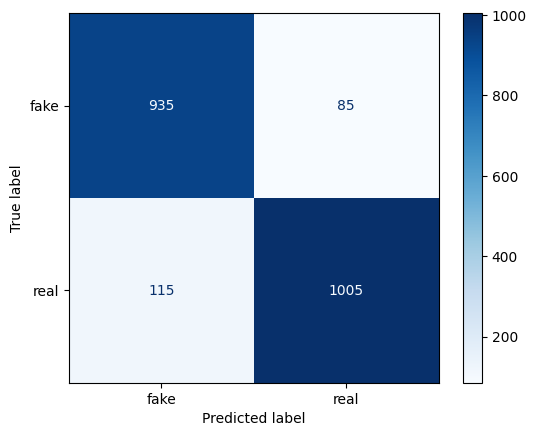

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1020
           1       0.92      0.90      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred))

As we can see, the accuracy of this model is quite high, and the confusion matrix shows promising results for the classification.

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">SHAP model explanation</div>

Now that we have a model able to predict whether a tweet is true or not, something we can do with it is measure how important the presence of certain tokens are to the truthfullness of said tweet.

If we assume that the model is 100% accurate, then we could use the shap library to figure out whether the different tokens present in the tweet are more or less responsible for its result. Obvioulsy in practice, the model might be wrong, so the token might be responsible for an erroneous result, but the high accuracy of the model will guarantuee us that we will have a high certainty of the importance of the aforementioned tokens.

In [17]:
import shap
shap.initjs()

In [22]:
# data = shap.sample(X_train.toarray(), 200, random_state=42)
# data = shap.kmeans(X_train.toarray(), 200)
# explainer = shap.KernelExplainer(best_model.decision_function, data, feature_names=tfidf.get_feature_names_out())

explainer = shap.SamplingExplainer(best_model.decision_function, np.zeros((1,X_test.shape[1])), feature_names=tfidf.get_feature_names_out(), output_names=['fake', 'real'], seed=42)


In [25]:
X_test[y_test == 0].shape
data_0 = shap.sample(X_test[y_test == 0].toarray(), 5, random_state=42)
data_1 = shap.sample(X_test[y_test == 1].toarray(), 5, random_state=42)
data_test = np.concatenate([data_0, data_1])

In [19]:
shap_values = explainer(pd.DataFrame(X_test.toarray(),columns=tfidf.get_feature_names_out()))


  0%|          | 0/2140 [00:00<?, ?it/s]

We can now see the impact on the model output for the different tokens on each input.

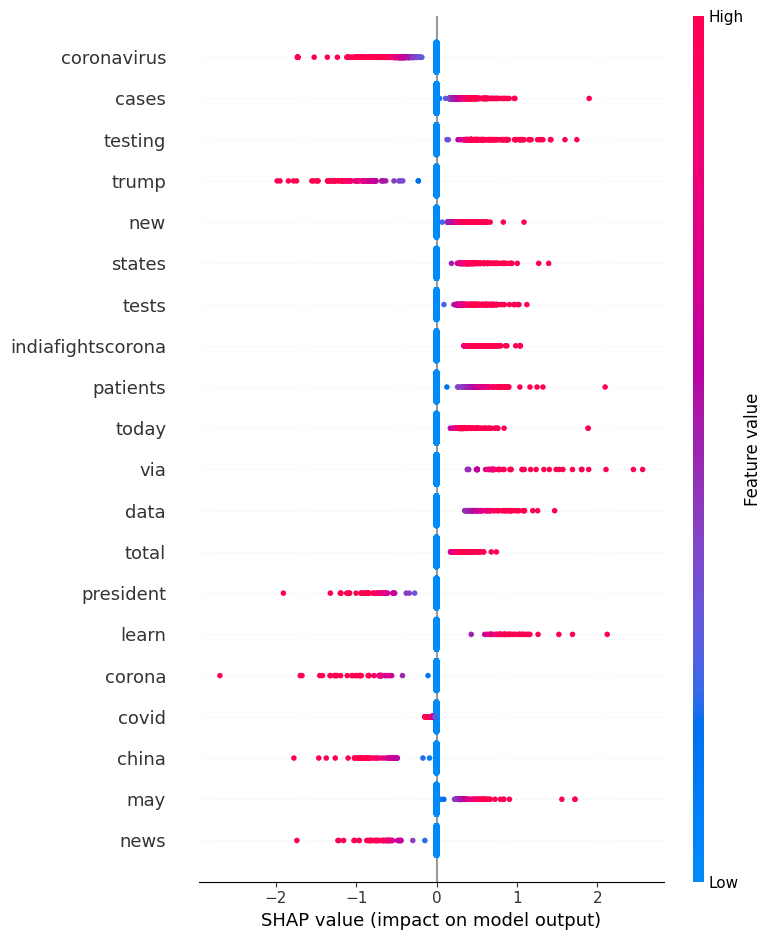

In [20]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out()
)
# y: palabras con mayor peso en la clasificación
# colores: valor TFIDF, rojo = alto, azul = bajo
# x: clase real hacia la derecha
# ejemplo: 'china' afecta más a la clasificación de 'fake'

We can see here, as espected, that mentions of china, trump or of a "cure" (not necesarily a vaccine, but cure) tend to influence the model for a fake prediction, and thus we can conclude that they might be mentioned in fake tweets more (their presence in a tweet implies it is more likely fake)

On the othe hand, the presence of cases, testing, data, or the keyword "patients" imply the tweet is more likely fake. We can also observe the presence of the keyword, indiafightscorona, from a hashtag, that implies a high probability of truth just by its presence on the tweet. It could imply that there is a community of people in india that tend to be more careful of not being misinformed around COVID.

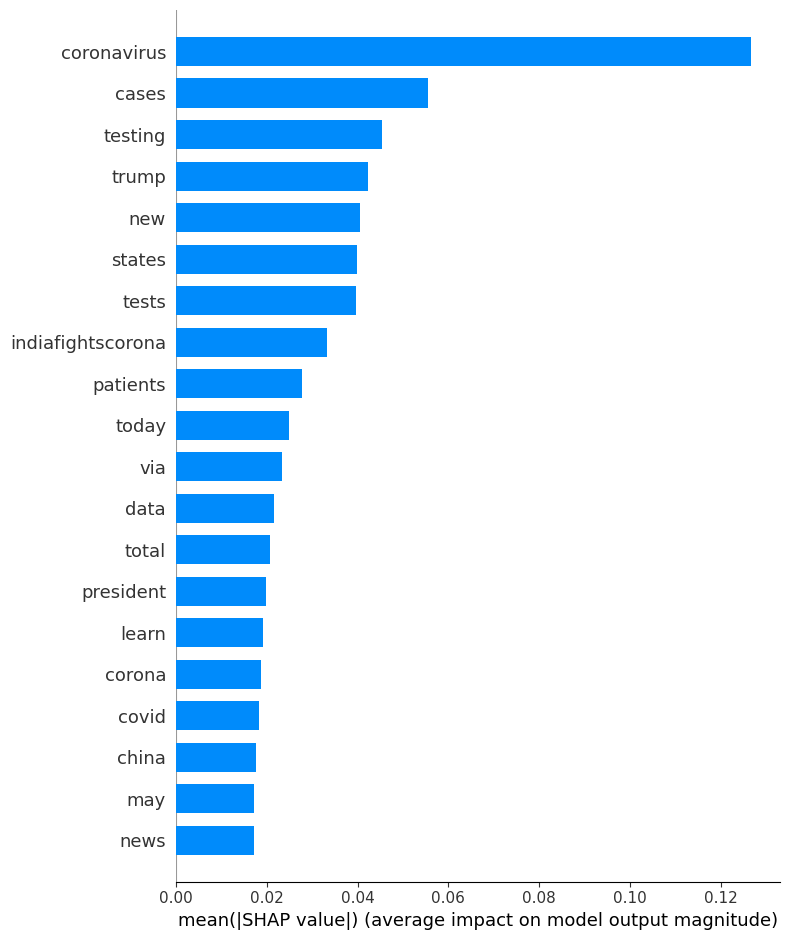

In [21]:
# Crear un bar plot
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out(), 
    plot_type="bar"
)

We can see below, some examples for the existing tweets with the tokens we saw in the bar plot.

In [29]:
from textwrap import wrap as _wrap

def wrap(s:str, w:int = 70) -> str:
    r = ""
    for i in _wrap(s,w):
        r+=i+"\n"
    return r

token_to_column_num = {j:i for i,j in enumerate(tfidf.get_feature_names_out())}

def print_token_examples(token:str,samples = 7,width=80):
    print(f"TOKEN: \x1b[1m{token}\x1b[0m")
    examples:pd.Series[str] = (
        tweets['tweet']
        .iloc[
            (X.getcol(token_to_column_num[token]) != 0).toarray().transpose().tolist()[0]
        ]
        .sample(samples)
    )
    for num,i in examples.items():
        
        color = 31 if tweets['label_mapped'][num] == 0 else 32
        t = re.compile(re.escape(token),re.IGNORECASE).sub(f'\x1b[1m{token}\x1b[0m\x1b[{color}m',i)
        [t[i:i+50] for i in range(len(t))]
        # t = i.replace(token,f'\x1b[1m{token}\x1b[0m\x1b[{color}m')
        print(wrap(f"\x1b[{color}m{t}\x1b[0m",width))
        print(f"---")

In [39]:
print_token_examples('coronavirus')

TOKEN: coronavirus
coronavirus: 'Rule of six' comes into force as medics warn of
second COVID-19 peak https://t.co/amKlnE1X4V

---
Visiting kids excited to give mom the gift of coronavirus
https://t.co/ZaSNhzRYuO #mothersday #thankyoumom

---
Another reason is the casual attitude of people towards #COVID_19 as people
are seen in crowded places without any taking any precautionary measures such as
wearing a #facemask maintaining #SocialDistancing etc. resulting in people
getting infected with the #novel #coronavirus.

---
Videos show pigs being buried in China due to the coronavirus
outbreak.

---
India reported over 60000 new cases taking the country’s confirmed case
tally to 23.2 lakh. Union Minister of State for AYUSH Shripad Y Naik tested
positive for the novel coronavirus. #Corona
#coronavirusPandemic #coronavirusUpdates
https://t.co/B7bNezGh2s

---
Says BBC prematurely reported ???Ghislaine Maxwell moved to intensive care
as coronavirus symptoms worsen.??�

---
a study found that 

In [40]:
print_token_examples('cases')

TOKEN: cases
Four other cases are contacts of previously reported confirmed
cases. ​ ​ The remaining person who has tested positive for
COVID-19 is being interviewed today to determine their possible links to the
cluster.

---
The recommended duration of quarantine for #COVID19 cases is
up to 14 days from the time of exposure. Kindly refer to the following documents
for details: https://t.co/nzpxLnPDoF & https://t.co/ZbRoOVI5ni #COVID__19 #COVID
#COVID_19 #COVIDー19 #COVID19India #Corona #coronavirus
https://t.co/eU2yjqgwrU

---
The number of schools in England that are not fully open to students due to
cases of COVID-19 has quadrupled in a week
https://t.co/PWIZPYcbUq

---
???Breaking UK Prepares For Full Lockdown After Hundreds Of New
cases ??" Wuhan Super Virus Updates.??�

---
93% of the (COVID-19) cases in the state of Illinois have come
from Chicago.

---
328 new cases of #COVID19; Lagos-121 FCT-70 Bauchi-25
Rivers-18 Oyo-16 Kaduna-15 Gombe-14 Edo-13 Ogun-13 Jigawa-8 Enugu-6 Kano-

In [41]:
print_token_examples('testing')

TOKEN: testing
We're pleased to announce the activation of 2 new labs for inclusion in the
NCDC Molecular Laboratory Network: 🧪Afriglobal Medicare Lab Ogun 🧪Sahel Centre
for Molecular Diagnostics & Research Katsina This brings the total number of
labs with #COVID19 testing capacity to 28
https://t.co/HcLVzMbHYl

---
As India rides the wave of very HIGH testing several
States/UTs have demonstrated better #COVID19 response with higher Tests Per
Million (TPM) and commensurate lower Positivity Rate than the national
average.

---
#CoronaVirusUpdates: #COVID19 testing status update:
@ICMRDELHI stated that 062454254 samples tested up to September 18 2020 0881911
samples tested on September 18 2020 #StaySafe #IndiaWillWin
https://t.co/woTsjKCV4D

---
#IndiaFightsCorona Focused and effective efforts of containment
testing isolation and treatment have resulted in increasing
percentage recovery rates and steadily falling percentage active cases.
https://t.co/GWHeeWBb9s

---
One hundred days afte

In [42]:
print_token_examples('trump')

TOKEN: trump
trump offers to pardon coronavirus #NewsInPhoto #covid19
#CoronaVirusNYC https://t.co/LzcG7RfbKh

---
Yes I better buy my aspirin, nose spray and fiber. Sniffle, sniffle, run to
the can, the anti trump virus is in its 2nd wave. Fabreese
anyone?

---
It’s been over six months since the first confirmed case of COVID-19 in the
United States, and President trump still doesn't have an effective
plan to contain its spread. It's an unjustifiable failure of leadership that
costs lives every day.

---
my news apps send me articles like “trump’s tax records are
going to bring down his campaign” like. no they’re not. none of his supporters
care. he used covid 19 like a bioweapon against the american people (just like
he said china would) and they still don’t care

---
A WhatsApp forward claims that the COVID-19 vaccine is ready was announced
by U.S. President Donald trump and will be launched next Sunday. It
also claims that the vaccine discovered by the U.S. scientists can cure a
CO

In [43]:
print_token_examples('new')

TOKEN: new
• We still have 16 significant clusters four of which are now closed. ⁣ ⁣ •
Yesterday our laboratories processed 5961 tests bringing the total number of
tests completed to date to 203045 - just over 4% of new
Zealanders.⁣

---
#IndiaFightsCorona India continues to scale new heights in
COVID-19 tests. Over 11.5 lakh tests conducted in the last 24 hour.
https://t.co/Vn2LXxEWPR https://t.co/w0A8m6yEWl

---
COVID-19 Update There are two new cases of COVID-19 to report
in managed isolation in new Zealand today. ​ ​ It has been 92 days
since the last case of COVID-19 was acquired locally from an unknown source.

---
Our daily update is published. We’ve now tracked 22.5 million tests up 584k
from yesterday a new all-time high. Here are the states that
reported over 10k new tests. For details see:
https://t.co/PZrmH4bl5Y https://t.co/eoB2jEZzuU

---
1651 deaths were reported bringing the total in our dataset to 60710. This
does not include 5126 probable COVID-19 deaths reported by N

In [44]:
print_token_examples('states')

TOKEN: states
states reported 782 new deaths. The 7-day average is now ~650.
We've only had one day in June where states reported more than 1000
deaths. Today's deaths—because of the duration of the disease and data reporting
lags—probably reflect infections that occurred in mid-May.
https://t.co/b4qyQz2tkM

---
18 states posted record highs for new cases since Sunday 35%
of US states. https://t.co/4qR9G9LkgL

---
As of March 11 81 state and local public health labs in 50
states and the DC have successfully verified and are using COVID-19
diagnostic tests. Contact your state health department regarding questions about
testing. For the latest on testing from CDC: https://t.co/7IRVqRCIXV
https://t.co/MDbikv8unC

---
states reported 619 deaths. The 7-day average fell to 556.
https://t.co/FoymaF05NK

---
Deaths are now rising quickly in the states where cases and
hospitalizations have been increasing over the past month. This is a growing
segment of the country and will likely continue. ht

In [46]:
print_token_examples('tests')

TOKEN: tests
Our daily update is published. We’ve now tracked ~14.2 million
tests up 380k from yesterday. Note that we can only track
tests that a state reports. For details see:
https://t.co/PZrmH4bl5Y https://t.co/5JM0ZoTHYO

---
One person remains in Auckland City Hospital in a stable condition on a
ward.​ ​ Yesterday our laboratories completed 1057 tests bringing
the total number of tests completed to date to 415283.

---
RT @PIB_India: #IndiaFightsCorona Average Daily tests
Conducted (week wise) India has set a record in #COVID19 tests
conducted per day.…

---
Yesterday our laboratories completed ​1043 tests. That brings
the total number of tests completed to date to 429643. Please note
that testing numbers are usually lower on the weekend.

---
We've locked our daily update. Here are the toplines: Total positive cases:
7731 Total negative tests we could document: 66225 Total
tests we could document: 76495 All the data is here please read the
caveats: https://t.co/xAVNgvskpp

---


The token  `#indiafightscorona` is notable, in that it is the only one related with a specific country. This makes some sense because of the large population of the country, as well as the impact the virus had there. The fact it is primarily composed of truthful tweets may imply indian people tended to be better informed during the pandemic, although it could just mean there is a subcommunnity of indian people who are better informed, and they are all communicating under this hashtag.

In [58]:
print_token_examples('indiafightscorona')

TOKEN: indiafightscorona
#indiafightscorona: 📍SOP for partial reopening of Schools 🏫
(w.e.f. today- 21st September 2020) ✅ For conducting guidance activities 👇
#StaySafe #IndiaWillWin https://t.co/O6ckEakD6B

---
#indiafightscorona India records highest ever single day
recoveries of 54859 today. Recoveries exceed active cases by more than 9 lakh.
Case Fatality Rate touches a new low of 2%. https://t.co/2hEonhvRaA @PMOIndia
@drharshvardhan @AshwiniKChoubey @PIB_India @COVIDNewsByMIB

---
#CoronaVirusUpdates #indiafightscorona India conducts a record
high of more than 8.3 lakh tests for #COVID19 in a single day. Week-wise average
daily tests saw a sharp increase from around 2.3 lakh in the first week of July
'20 to more than 6.3 lakh in the current week. https://t.co/bFVShH7hNZ

---
True that!! This is an imp piece of info.   If You're planning to order
FabiFlu online, favipiravir-#DCGI approved medication for the treatment of mild
#Covid19, you need to upload the docs prescription sheet

In [59]:
print_token_examples('patients')

TOKEN: patients
Imported #N95s are ineffective against #COVID19 raising the risk of
infection to HCPs and patients. https://t.co/mlwGuNmSn1

---
#TERAVOLT registry: Past treatment may impact risk of death in
patients with thoracic malignancies who develop #COVID-19.
https://t.co/MDwSBRWOfv #ASCO20 #lcsm https://t.co/0pgDJKgdBk

---
Four people are in hospital with COVID-19 – one each at Auckland City and
North Shore hospitals and two in Middlemore. All four patients are
in isolation on a general ward.

---
Ophthalmologist fears for his patients’ “untoward morbidityas
they delay care due to #COVID19. https://t.co/TKuRP8lZ0h

---
Clinicians must quickly recognize symptoms and immediately hospitalize
patients with this polio-like disease. https://t.co/QRmfLpkG0i

---
Video shows COVID-19 patients lying dead on the ground in
India.

---
Florida’s data is for “hospitalizations with primary diagnosis of COVID.”
We're unsure how this definition compares to other states' reporting. Many of
the